### To do 

gal['data'].shape = 3, npix, npix -> gal['img'], gal['mask'], gal['weight'].   'mask' needs to be boolean.

In [1]:
import matplotlib as mpl
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

from astrobf.run import Full_exp
from astrobf.analysis.binary_clustering import *
from astrobf.analysis.utils import *

#import statmorph
import time



import random
import importlib

mpl.rcParams['savefig.facecolor'] = 'white'

## AX
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient

## 1. Load the all-in-one data

### All_gals data

all-gals is a list of dictionaries, each of which contains 
(ndarray image, string image_name, and slices slice)


In [2]:
fn = "../../bf_data/Nair_and_Abraham_2010/all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

### 2. Load galaxy catalog data and initial morph measurements

Just in case, only for the initial morphology measurement, full results are saved. 

In [3]:
from astrobf.utils.misc import load_Nair
importlib.reload(astrobf.utils.misc)

cat_data = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')
# pd dataframe

good_gids = np.array([gal['img_name'] for gal in all_gals])
cat = cat_data[cat_data['ID'].isin(good_gids)]
# Leave only needed fields.

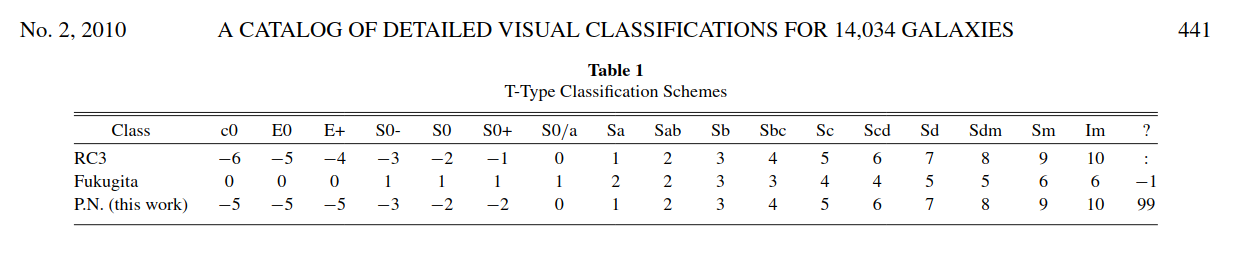

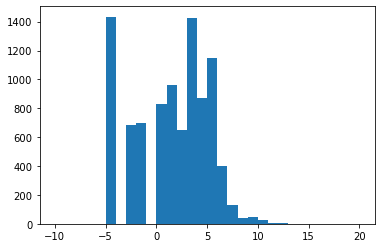

In [4]:
plt.hist(cat['TT'], range=[-10,20], bins=30)
plt.show()

2 groups : [-5, -1],        [3,5]

4 groups : [-5, -1], [0,2], [3,5], [6,9]  

6 groups : [-5,-5], [-3, -1], [0,2], [3,4], [5,6], [7,9]

8 groups : [-5,-5], [-3, -1], [0,1], [2,3], [4,5], [6,7], [8,9], [10, ~]

# Run Bayesian Optimization loop

### Initialize BO loop -  Measure morphology features

In [5]:
## Runtime config.

fields = ['gini', 'm20']#, 'concentration', 'asymmetry', 'smoothness']
label_field = 'TT'


ngroups = 4

bins = [[-5,0,3,6,10], 
        [-5,0,3,6,10], 
        [-5,-3,0,3,5,7,10], 
        [-5,-3,0,2,4,6,8,10,15]]
bin_masks = [[1,0,1,0,0], 
             [1,1,1,1,0], 
             [1,1,1,1,1,1,0],
             [1,1,1,1,1,1,1,1,0]]

this_bin = bins[1]
bin_mask = bin_masks[1]

In [6]:
from astrobf.morph import custom_morph

def labeler(results, bins, field='ttype'):
    return np.digitize(results[field], bins, right=False) -1


def sample_in_bins(cat, ngroups, label_field='TT'):
    cat.loc[:, 'label'] = labeler(cat, bins=this_bin, field=label_field) # pd automatically appends a new column

    uind = cat['label'].unique()
    
    assert len(uind) == len(bin_mask)
    glabels_keep = [i for i,flag in zip(uind, bin_mask) if flag]

    return cat[cat['label'].isin(glabels_keep)].to_records(index=False)

subcat = sample_in_bins(cat, ngroups)
print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]

# of sub sample: 9313


/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Catalog에서 outlier를 버렸으므로 원래의 catalog/all_gals보다 길이가 짧은 result_arr가 나옴. 
시작할 때 sample을 정하고, 나머지는 잘라버린 뒤에 optimization을 수행하는게 맞을 듯. 

그럼 good_gids도 업데이트해야됨. 


이거 머리 아프니까 한 덩어리로 합치면 좋겠는데.! 

class dataset():
    def __init__(self):

In [10]:
from functools import partial

def evaluate(params, cluster_method="agglomerate", eval_method='sample-weighted FMS'):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(custom_morph.step_simple_morph(sub_gals, 
                                                          plist[i], 
                                                          np.where(subcat['label'] == i)[0]))
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]    
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=['gini', 'm20'], 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

In [11]:
params_test = {'b0': 1,'c0': 2,'dl0': 3,'dh0': 4,
               'b1': 1,'c1': 2,'dl1': 3,'dh1': 4,
               'b2': 1,'c2': 2,'dl2': 3,'dh2': 4,
               'b3': 1,'c3': 2,'dl3': 3,'dh3': 4}

In [ ]:
ax_params = []
for i in range(ngroups):
    ax_params.append(
        {"name":f"b{i}", "type":"range", "bounds":[1.5,8.0], "value_type":"float"})
    ax_params.append(
        {"name":f"c{i}", "type":"range", "bounds":[1.5,8.0], "value_type":"float"})
    ax_params.append(
        {"name":f"dl{i}", "type":"range", "bounds":[1.0,15.0], "value_type":"float"})
    ax_params.append(
        {"name":f"dh{i}", "type":"range", "bounds":[1.0,15.0], "value_type":"float"})

# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./Experiments/'

for fn_result, cluster_method in zip(["FMS_2G_2p_ward", "FMS_2G_2p_spec", "FMS_2G_2p_agg"][:1],
                                     ['ward', 'spectral', 'agglomerate'][:1]):

    axc = AxClient()

    axc.create_experiment(
        parameters=ax_params,
        objective_name="mymetric",
        #minimize=True,  # Optional, defaults to False.
        parameter_constraints=[f"b{i} - dl{i} <= 100" for i in range(ngroups)], # all images are stretched to 100
        overwrite_existing_experiment =True,
        outcome_constraints=["total_flux >= 1e-5"],  # Optional.
    )

    all_metrics=[]
    for i in range(500):
        parameters, trial_index = axc.get_next_trial()
        axc.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters, cluster_method=cluster_method))
        if i % 50 == 49:
            print(f"{i}-th done")

    pickle.dump(all_metrics, open(exp_dir+fn_result+"_all_metrics.pickle", "wb"))

    if True:
        axc.save_to_json_file(exp_dir+fn_result+".json")
    else:
        axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

[INFO 05-21 16:23:58] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 05-21 16:23:58] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 16 trials, GPEI for subsequent trials]). Iterations after 16 will take longer to generate due to  model-fitting.
[INFO 05-21 16:23:58] ax.service.ax_client: Generated new trial 0 with parameters {'b0': 3.04, 'c0': 7.01, 'dl0': 10.84, 'dh0': 6.08, 'b1': 4.75, 'c1': 7.15, 'dl1': 11.81, 'dh1': 11.54, 'b2': 4.73, 'c2': 7.32, 'dl2': 5.96, 'dh2': 7.85, 'b3': 2.68, 'c3': 2.26, 'dl3': 13.05, 'dh3': 12.84}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-4aa0b065159f>:14: FutureWarning:

elementwise == comparison failed and returning scalar inst

Is every element matched?:  True
Label 1 samples 11156/9313
cluter_method ward
ward


[INFO 05-21 16:24:12] ax.service.ax_client: Completed trial 0 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-21 16:24:12] ax.service.ax_client: Generated new trial 1 with parameters {'b0': 4.33, 'c0': 2.56, 'dl0': 3.83, 'dh0': 14.93, 'b1': 5.1, 'c1': 7.86, 'dl1': 6.56, 'dh1': 8.3, 'b2': 4.1, 'c2': 6.0, 'dl2': 10.99, 'dh2': 11.28, 'b3': 1.83, 'c3': 3.36, 'dl3': 14.86, 'dh3': 13.81}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-4aa0b065159f>:14: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 11156/9313
cluter_method ward
ward


[INFO 05-21 16:24:25] ax.service.ax_client: Completed trial 1 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-21 16:24:25] ax.service.ax_client: Generated new trial 2 with parameters {'b0': 3.04, 'c0': 2.74, 'dl0': 5.08, 'dh0': 13.72, 'b1': 2.45, 'c1': 4.02, 'dl1': 9.94, 'dh1': 11.07, 'b2': 4.5, 'c2': 6.5, 'dl2': 11.63, 'dh2': 10.73, 'b3': 2.59, 'c3': 1.7, 'dl3': 3.69, 'dh3': 6.81}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-4aa0b065159f>:14: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 11156/9313
cluter_method ward
ward


[INFO 05-21 16:24:39] ax.service.ax_client: Completed trial 2 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-21 16:24:39] ax.service.ax_client: Generated new trial 3 with parameters {'b0': 7.11, 'c0': 7.98, 'dl0': 10.84, 'dh0': 4.63, 'b1': 5.32, 'c1': 5.32, 'dl1': 9.75, 'dh1': 7.4, 'b2': 1.71, 'c2': 5.53, 'dl2': 12.55, 'dh2': 7.02, 'b3': 4.16, 'c3': 6.15, 'dl3': 11.85, 'dh3': 4.08}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-4aa0b065159f>:14: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 11156/9313
cluter_method ward
ward


[INFO 05-21 16:24:53] ax.service.ax_client: Completed trial 3 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 05-21 16:24:53] ax.service.ax_client: Generated new trial 4 with parameters {'b0': 3.79, 'c0': 4.77, 'dl0': 4.28, 'dh0': 2.92, 'b1': 2.35, 'c1': 3.74, 'dl1': 3.31, 'dh1': 2.12, 'b2': 1.68, 'c2': 5.23, 'dl2': 6.46, 'dh2': 3.72, 'b3': 4.44, 'c3': 5.28, 'dl3': 4.79, 'dh3': 4.44}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-4aa0b065159f>:14: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 11156/9313
cluter_method ward
ward


[INFO 05-21 16:25:07] ax.service.ax_client: Completed trial 4 with data: {'mymetric': (0.46000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-21 16:25:07] ax.service.ax_client: Generated new trial 5 with parameters {'b0': 6.66, 'c0': 7.45, 'dl0': 12.83, 'dh0': 13.6, 'b1': 1.79, 'c1': 5.42, 'dl1': 1.43, 'dh1': 12.58, 'b2': 4.15, 'c2': 6.85, 'dl2': 1.66, 'dh2': 11.56, 'b3': 6.08, 'c3': 4.4, 'dl3': 5.77, 'dh3': 14.16}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-4aa0b065159f>:14: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 05-21 16:25:12] ax.service.ax_client: Completed trial 5 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 05-21 16:25:12] ax.service.ax_client: Generated new trial 6 with parameters {'b0': 7.22, 'c0': 5.98, 'dl0': 8.04, 'dh0': 12.77, 'b1': 1.5, 'c1': 6.35, 'dl

Is every element matched?:  True
Label 1 samples 11156/9313
cluter_method ward
ward


[INFO 05-21 16:25:26] ax.service.ax_client: Completed trial 6 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 05-21 16:25:26] ax.service.ax_client: Generated new trial 7 with parameters {'b0': 3.57, 'c0': 3.38, 'dl0': 6.4, 'dh0': 3.7, 'b1': 2.15, 'c1': 2.25, 'dl1': 9.65, 'dh1': 9.56, 'b2': 2.89, 'c2': 4.19, 'dl2': 14.97, 'dh2': 5.48, 'b3': 4.89, 'c3': 3.87, 'dl3': 5.83, 'dh3': 4.08}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-4aa0b065159f>:14: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 11156/9313
cluter_method ward
ward


[INFO 05-21 16:25:40] ax.service.ax_client: Completed trial 7 with data: {'mymetric': (0.55000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 05-21 16:25:40] ax.service.ax_client: Generated new trial 8 with parameters {'b0': 5.42, 'c0': 5.76, 'dl0': 2.35, 'dh0': 6.84, 'b1': 3.72, 'c1': 4.18, 'dl1': 5.33, 'dh1': 13.65, 'b2': 2.24, 'c2': 4.89, 'dl2': 6.81, 'dh2': 5.92, 'b3': 6.19, 'c3': 2.52, 'dl3': 8.71, 'dh3': 10.41}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

[INFO 05-21 16:25:40] ax.service.ax_client: Completed trial 8 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 05-21 16:25:40] ax.service.ax_client: Generated new trial 9 with parameters {'b0': 3.47, 'c0': 6.47, 'dl0': 7.08, 'dh0': 4.26, 'b1': 5.39, 'c1': 2.42, 'dl1': 14.69, 'dh1': 2.69, 'b2': 2.69, 'c2': 7.68, 'dl2': 10.59, 'dh2': 2.23, 'b3': 3.18, 'c3': 4.7, 'dl3': 9.01, 'dh3': 13.68}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWar

Is every element matched?:  True
Label 1 samples 11156/9313
cluter_method ward
ward


[INFO 05-21 16:25:54] ax.service.ax_client: Completed trial 9 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-21 16:25:54] ax.service.ax_client: Generated new trial 10 with parameters {'b0': 6.45, 'c0': 4.71, 'dl0': 4.22, 'dh0': 9.17, 'b1': 4.16, 'c1': 2.88, 'dl1': 2.81, 'dh1': 14.55, 'b2': 2.33, 'c2': 2.74, 'dl2': 4.58, 'dh2': 6.03, 'b3': 2.33, 'c3': 1.8, 'dl3': 4.62, 'dh3': 13.98}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

[INFO 05-21 16:25:54] ax.service.ax_client: Completed trial 10 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 05-21 16:25:54] ax.service.ax_client: Generated new trial 11 with parameters {'b0': 2.14, 'c0': 3.79, 'dl0': 8.16, 'dh0': 13.29, 'b1': 6.19, 'c1': 4.07, 'dl1': 7.73, 'dh1': 4.25, 'b2': 3.38, 'c2': 5.31, 'dl2': 9.21, 'dh2': 7.63, 'b3': 3.89, 'c3': 7.4, 'dl3': 2.27, 'dh3': 8.92}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWar

In [6]:
# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./Experiments/'

for fn_result, cluster_method in zip(["FMS_2G_2p_spec", "FMS_2G_2p_agg", "FMS_2G_2p_ward"],
                                     ['spectral', 'agglomerate', 'ward']):

    axc = AxClient()

    axc.create_experiment(
        parameters=[
            {"name": "b",
            "type": "range",
            "bounds": [1.0, 4.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False},
            {"name": "b2",
            "type": "range",
            "bounds": [1.0, 4.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False},
            {"name": "c",
            "type": "range",
            "bounds": [0.5, 5.0]},
            {"name": "c2",
            "type": "range",
            "bounds": [0.5, 5.0]},
            {"name": "dl",
            "type": "range",
            "bounds": [0.5, 8.0]},
            {"name": "dl2",
            "type": "range",
            "bounds": [0.5, 8.0]},
            {"name": "dh",
            "type": "range",
            "bounds": [0.5, 8.0]},
            {"name": "dh2",
            "type": "range",
            "bounds": [0.5, 8.0]},
        ],
        objective_name="mymetric",
        #minimize=True,  # Optional, defaults to False.
        parameter_constraints=["b - dl <= 100"], # all images are stretched to 100
        overwrite_existing_experiment =True,
        outcome_constraints=["total_flux >= 1e-5"],  # Optional.
    )

    all_metrics=[]
    for i in range(500):
        parameters, trial_index = axc.get_next_trial()
        axc.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters, cluster_method=cluster_method))
        if i % 50 == 49:
            print(f"{i}-th done")

    pickle.dump(all_metrics, open(exp_dir+fn_result+"_all_metrics.pickle", "wb"))

    if True:
        axc.save_to_json_file(exp_dir+fn_result+".json")
    else:
        axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

[INFO 05-20 12:34:21] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 05-20 12:34:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-20 12:34:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c2. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-20 12:34:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter dl. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-20 12:34:21] ax.service.util

KeyboardInterrupt: 

In [47]:
importlib.reload(Full_exp)

<module 'astrobf.run.Full_exp' from '/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py'>

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
for i in [0,1,2,5,9]:
    values =[al[i][1] for al in all_metrics] 
    ax.plot(values / np.max(values), label=all_metrics[0][i][0])
ax.legend()
plt.show()
plt.savefig(fn_result+"param_evol.png")

print(axc.generation_strategy.trials_as_df)
render(axc.get_optimization_trace())

best_parameters, values = axc.get_best_parameters()
from astrobf.tmo import Mantiuk_Seidel
plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **best_parameters))

[INFO 05-16 22:55:42] ax.service.ax_client: Generated new trial 0 with parameters {'b': 6.75, 'c': 5.71, 'dl': 5.07, 'dh': 4.69}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:55:51] ax.service.ax_client: Completed trial 0 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:55:51] ax.service.ax_client: Generated new trial 1 with parameters {'b': 6.11, 'c': 3.06, 'dl': 2.47, 'dh': 7.59}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

[INFO 05-16 22:55:51] ax.service.ax_client: Completed trial 1 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.
[INFO 05-16 22:55:51] ax.service.ax_client: Generated new trial 2 with parameters {'b': 5.42, 'c': 5.11, 'dl': 4.06, 'dh': 1.1}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:55:59] ax.service.ax_client: Completed trial 2 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:55:59] ax.service.ax_client: Generated new trial 3 with parameters {'b': 4.39, 'c': 8.58, 'dl': 5.13, 'dh': 1.14}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:56:11] ax.service.ax_client: Completed trial 3 with data: {'mymetric': (0.56999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:56:11] ax.service.ax_client: Generated new trial 4 with parameters {'b': 4.63, 'c': 6.1, 'dl': 5.14, 'dh': 3.34}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:56:23] ax.service.ax_client: Completed trial 4 with data: {'mymetric': (0.53000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:56:24] ax.service.ax_client: Generated new trial 5 with parameters {'b': 6.95, 'c': 6.7, 'dl': 5.38, 'dh': 2.4}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:56:32] ax.service.ax_client: Completed trial 5 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:56:33] ax.service.ax_client: Generated new trial 6 with parameters {'b': 6.74, 'c': 3.97, 'dl': 5.96, 'dh': 3.07}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:56:42] ax.service.ax_client: Completed trial 6 with data: {'mymetric': (0.57999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:56:43] ax.service.ax_client: Generated new trial 7 with parameters {'b': 6.88, 'c': 7.49, 'dl': 6.25, 'dh': 4.83}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:56:52] ax.service.ax_client: Completed trial 7 with data: {'mymetric': (0.57999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:56:52] ax.service.ax_client: Generated new trial 8 with parameters {'b': 6.13, 'c': 8.02, 'dl': 3.98, 'dh': 2.56}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

[INFO 05-16 22:56:52] ax.service.ax_client: Completed trial 8 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.
[INFO 05-16 22:56:53] ax.service.ax_client: Generated new trial 9 with parameters {'b': 5.27, 'c': 5.15, 'dl': 5.25, 'dh': 0.3}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:57:04] ax.service.ax_client: Completed trial 9 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:57:05] ax.service.ax_client: Generated new trial 10 with parameters {'b': 6.5, 'c': 5.79, 'dl': 5.78, 'dh': 3.5}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:57:14] ax.service.ax_client: Completed trial 10 with data: {'mymetric': (0.55000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:57:15] ax.service.ax_client: Generated new trial 11 with parameters {'b': 7.0, 'c': 5.72, 'dl': 6.06, 'dh': 4.01}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:57:25] ax.service.ax_client: Completed trial 11 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:57:25] ax.service.ax_client: Generated new trial 12 with parameters {'b': 5.5, 'c': 3.27, 'dl': 4.4, 'dh': 0.9}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10

<ipython-input-10-d252df7c08e2>:15: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
Label 1 samples 3869/9536


[INFO 05-16 22:57:34] ax.service.ax_client: Completed trial 12 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 05-16 22:57:35] ax.service.ax_client: Generated new trial 13 with parameters {'b': 3.83, 'c': 4.89, 'dl': 4.35, 'dh': 0.2}.
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



## Prototypical samples

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


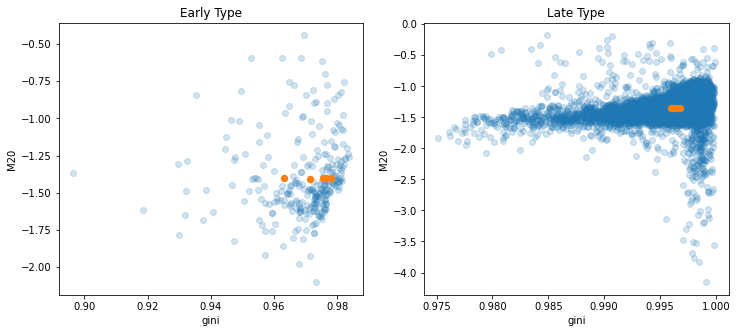

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



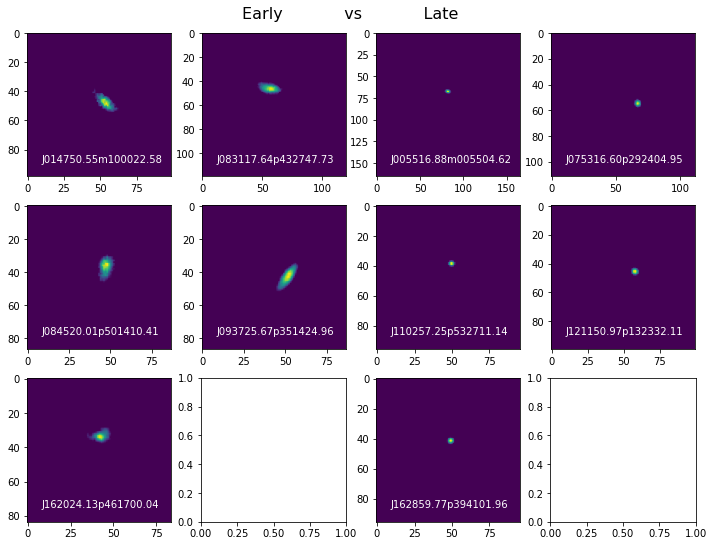

In [51]:
from astrobf import analysis
from astrobf.analysis import binary_clustering

best_parameters, values = axc.get_best_parameters()
best_results = custom_morph.step_simple_morph(all_gals, best_parameters)
Full_exp.add_ttype(best_results, cat)

eval_metrics, clustering = Full_exp.do_ML(best_results, labeler, cat,
                                         fields=['gini', 'm20'], 
                                         return_cluster=True,
                                         cluster_method="ward",
                                         eval_weight='area')

# Get centroids (typicals)
clu1 = best_results[clustering.labels_.astype(bool)]
clu2 = best_results[~clustering.labels_.astype(bool)]

tmo_params = best_parameters
t_ind_E = analysis.utils.get_typical_ind(clu1, n_samples=5)
t_ind_L = analysis.utils.get_typical_ind(clu2, n_samples=5)

typicals = []

fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
for ax, group in zip(axs, [clu1, clu2]):
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['m20'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    
    typicals.append([gal for gal in all_gals if gal['img_name'] in group['id'][t_ind]])

axs[0].set_title("Early Type")
axs[1].set_title("Late Type")

plt.show()

typical_E, typical_L = typicals
binary_clustering.plot_group_comparison(typical_E, typical_L, best_parameters, 
                      suptitle="Early            vs            Late")

## Typical sampes in incremental points 

### Get the 'incremental' points

AttributeError: 'list' object has no attribute 'xaxis'

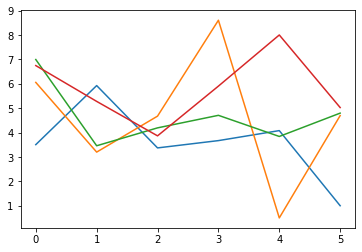

In [72]:
trace, t_ = axc.get_optimization_trace()

scores = np.array(trace['data'][0]['y'])
i_incr = [np.argmax(sc == scores) for sc in np.unique(scores)]

incr_params = [axc.get_trial_parameters(i) for i in i_incr]

# Change of the parameters over time
param_arr = np.zeros(len(incr_params), dtype=[(key, 'f') for key in incr_params[0].keys()])

for i, params in enumerate(incr_params):
    for key, val in params.items():
        param_arr[key][i] = val

for field in param_arr.dtype.names:
    plt.plot(param_arr[field], label=field)

plt.set_xticklabels([f"{scores[i]:.3f}" for i in i_incr])
plt.legend()
plt.xlabel("metric")
plt.ylabel("value")
plt.show()

Interestingly, the changes are somewhat unpredictable.

### Typical samples at each incremental point

TODO : support arbitrary numebr of clusters. 

In [87]:
typical_E_result = analysis.utils.get_matched_result(best_results, [gal['img_name'] for gal in typical_E])
typical_L_result = analysis.utils.get_matched_result(best_results, [gal['img_name'] for gal in typical_L])

for i, best_params in enumerate(incr_params):
    try:
        binary_clustering.plot_group_comparison(typical_L, typical_E, best_params,
                              fn=f'typical_{i}.png',
                              suptitle=f"scroe: {scores[i_incr[i]]:.4f}")


        this_results = custom_morph.step_simple_morph(all_gals, best_params)
        Full_exp.add_ttype(this_results, cat)

        eval_metrics, clustering = Full_exp.do_ML(this_results, labeler, cat,
                                         fields=['gini', 'm20'], 
                                         return_cluster=True,
                                         cluster_method="ward")

        # Get centroid
        clu0_this = this_results[clustering.labels_==0]
        clu1_this = this_results[clustering.labels_==1]
        clu2_this = this_results[clustering.labels_==2]
        clu3_this = this_results[clustering.labels_==3]

        typical_E_this_result = analysis.utils.get_matched_result(this_results, 
                                                   [gal['img_name'] for gal in typical_E])
        typical_L_this_result = analysis.utils.get_matched_result(this_results, 
                                                   [gal['img_name'] for gal in typical_L])

        binary_clustering.plot_group_evals_w_centers((clu1,clu2), 
                               (typical_E_result, typical_L_result),
                               (clu1_this, clu2_this), 
                               (typical_E_this_result, typical_L_this_result),
                               fn=f"G_M{i}.png")

        binary_clustering.plot_classification_vs_answer(this_results, (clu1, clu2), labeler,
                                        fn=f"current_in_best_color{i}.png")
    except:
        continue

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

invalid value encountered in log10



Is every element matched?:  True
Label 1 samples 3869/9536


## Train two sets of parameters for early / late samples.